In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F

In [ ]:
dev = "cpu"
if torch.cuda.is_available():
    dev = "cuda:0"

device = torch.device(dev)
print(device)

## Preparing dataset

In [81]:
import random
import math

class Mixer:
    def __init__(self):
        self.transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                        transforms.RandomHorizontalFlip(1),
                                        transforms.Pad(4),
                                        transforms.RandomCrop(32),
                                        ])
        
        self.no_transform = transforms.Compose([transforms.ToTensor()])
        self.cifar_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        self.cifar_test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    
    def mix_images_bc(self, img1, img2):
        #First between class mixing method proposed
        ratio = random.uniform(0.5, 1)
        while ratio == 0.5:
            ratio = random.uniform(0.5, 1)
        mixed_image = img1 * ratio + img2 * (1 - ratio)

        return mixed_image, ratio

    def mix_images_bc_plus(self, img1, img2):
        #Better mixing method
        ratio = random.uniform(0.5, 1)
        while ratio == 0.5:
            ratio = random.uniform(0.5, 1)
        i1_mean, i2_mean = torch.mean(img1), torch.mean(img2)
        i1_std, i2_std = torch.std(img1), torch.std(img2)
        p = 1 / (1 + (i1_std / i2_std) * ((1 - ratio) / ratio)) 

        mixed_image = (p * (img1 - i1_mean) + (1 - p) * (img2 - i2_mean)) / (math.sqrt(p ** 2 + (1 - p) ** 2))
        return mixed_image, ratio
        
    def get_test_dataset(self, transform = True):
        testing_size = len(self.cifar_test_set.data)
        original_test_set = torch.empty((testing_size, 3, 32, 32), dtype=float)
        original_test_set_label = []
        
        for i, data in enumerate(self.cifar_test_set.data):
            data = Image.fromarray(data)
            if transform:
                data = self.transform(data)
            else:
                data = self.no_transform(data)
            original_test_set[i] = data
            original_test_set_label.append(self.cifar_test_set.targets[i])

        original_test_set_label = F.one_hot(torch.tensor(original_test_set_label))

        return original_test_set, original_test_set_label

    def get_train_dataset(self, transform = True):
        training_size = len(self.cifar_train_set.data)
        original_train_set = torch.empty((training_size, 3, 32, 32), dtype=float)
        original_train_set_label = []
        
        for i, data in enumerate(self.cifar_train_set.data):
            data = Image.fromarray(data)
            if transform:
                data = self.transform(data)
            else:
                data = self.no_transform(data)
            original_train_set[i] = data
            original_train_set_label.append(self.cifar_train_set.targets[i])

        original_train_set_label = F.one_hot(torch.tensor(original_train_set_label))

        return original_train_set, original_train_set_label
        

    def mix_image_dataset(self, images, labels, algo="bc"):
        mixed_images = torch.empty(images.shape)
        mix_labels = torch.empty((images.shape[0], len(labels[0])))
        mix_ratios = torch.empty((images.shape[0]))
        mixing_algo = self.mix_images_bc_plus if algo == "bc+" else self.mix_images_bc
        total = 0

        random.seed(10)
        for offset in range(1, 100):
            if total >= images.shape[0]: break
            for i in range(images.shape[0] - 1):
                if total >= images.shape[0]: break
                if i + offset < images.shape[0] and not torch.all(torch.eq(labels[i], labels[i + offset])):
                    m_i, ratio = mixing_algo(images[i], images[i + offset])
                    mixed_images[i] = m_i
                    mix_labels[i] = labels[i]
                    mix_ratios[i] = ratio
                    total += 1

        
        return mixed_images, mix_labels, mix_ratios
            
                

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [82]:
mixer = Mixer()

original_train_set, original_train_set_label = mixer.get_train_dataset(transform=False)
original_test_set, original_test_set_label = mixer.get_test_dataset(transform=False)

transformed_train_set, transformed_train_set_label = mixer.get_train_dataset()
transformed_test_set, transformed_test_set_label = mixer.get_test_dataset()

mixed_train_images, mixed_train_labels, mix_train_ratios = mixer.mix_image_dataset(transformed_train_set, transformed_train_set_label, algo="bc")
plus_mixed_train_images, plus_mixed_train_labels, plus_mixed_train_ratios = mixer.mix_image_dataset(transformed_train_set, transformed_train_set_label, algo="bc+") 

mixed_test_images, mixed_test_labels, mixed_test_ratios = mixer.mix_image_dataset(transformed_test_set, transformed_test_set_label, algo="bc")
plus_mixed_test_images, plus_mixed_test_labels, plus_mixed_test_ratios = mixer.mix_image_dataset(transformed_test_set, transformed_test_set_label, algo="bc+") 

Files already downloaded and verified
Files already downloaded and verified


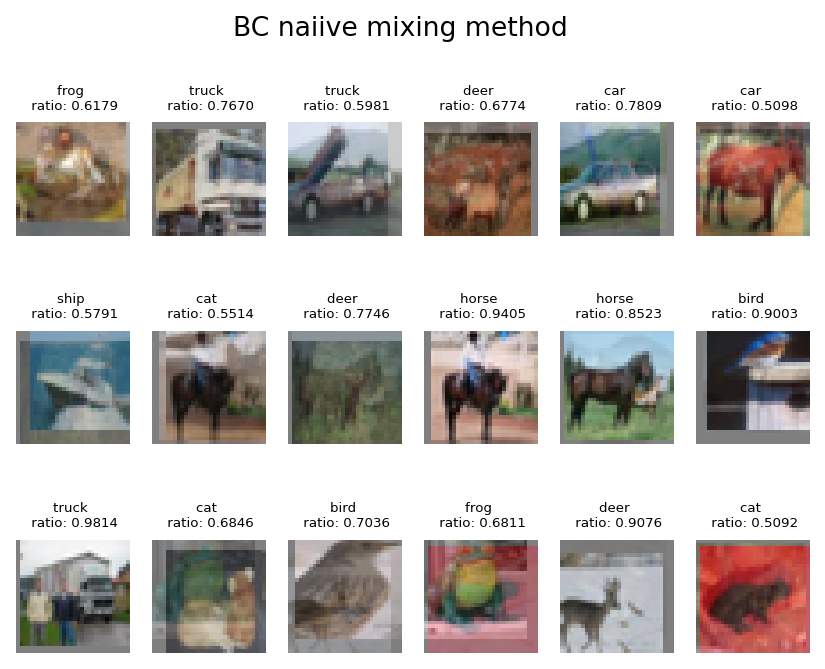

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

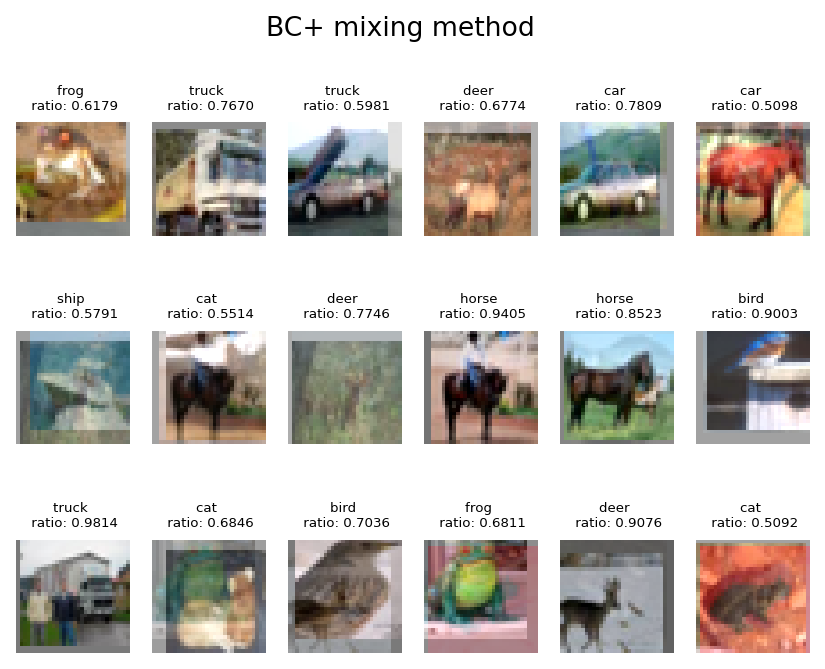

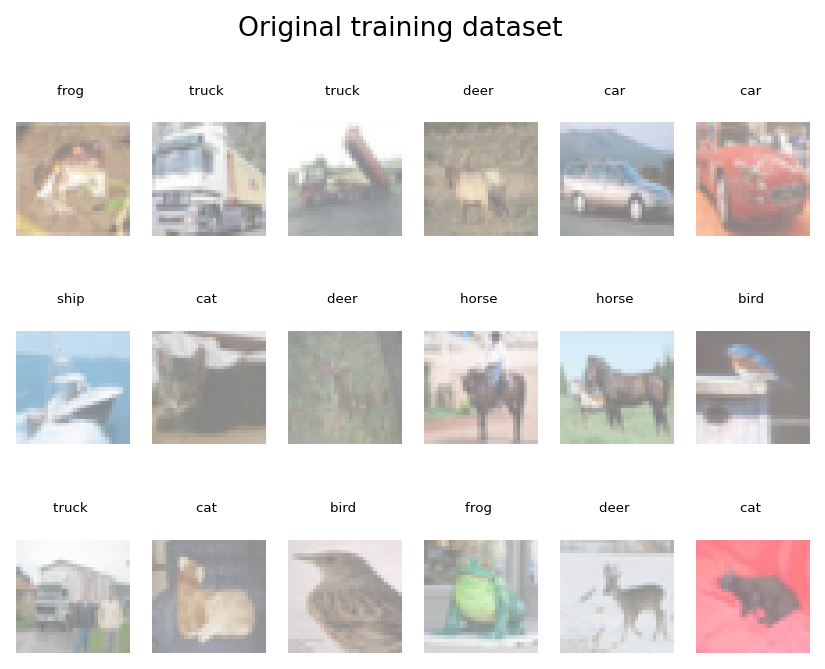

In [84]:
#Preview of the images within our mixed images
#BC naiive mixing method plot
fig, axs = plt.subplots(3, 6)
fig.set_dpi(160)
fig.suptitle("BC naiive mixing method")
for i in range(3):
    for j in range(6):
        r_index = i * 8 + j
        img = mixed_train_images[r_index] / 2 + 0.5
        axs[i, j].imshow(np.transpose(img, (1, 2,0)))
        axs[i, j].axis('off')
        image_label = torch.nonzero(mixed_train_labels[r_index])
        axs[i,j].set_title("{} \n ratio: {:.4f}".format(classes[image_label[0]], float(mix_train_ratios[r_index])),
        fontdict={'fontsize':6})

plt.show()

#BC+ mixing method plot
fig, axs = plt.subplots(3, 6)
fig.set_dpi(160)
fig.suptitle("BC+ mixing method")
for i in range(3):
    for j in range(6):
        r_index = i * 8 + j
        img = plus_mixed_train_images[r_index] / 2 + 0.5
        axs[i, j].imshow(np.transpose(img, (1, 2,0)))
        axs[i, j].axis('off')
        image_label = torch.nonzero(plus_mixed_train_labels[r_index])
        axs[i,j].set_title("{} \n ratio: {:.4f}".format(classes[image_label[0]], float(plus_mixed_train_ratios[r_index])),
        fontdict={'fontsize':6})

plt.show()

#Training dataset
fig, axs = plt.subplots(3, 6)
fig.set_dpi(160)
fig.suptitle("Original training dataset")
for i in range(3):
    for j in range(6):
        r_index = i * 8 + j
        img = original_train_set[r_index] / 2 + 0.5
        axs[i, j].imshow(np.transpose(img, (1, 2,0)))
        axs[i, j].axis('off')
        image_label = torch.nonzero(original_train_set_label[r_index])
        axs[i,j].set_title("{} \n".format(classes[image_label[0]]),
        fontdict={'fontsize':6})

plt.show()

In [6]:
from torch.utils.data import Dataset

class DatasetIterator(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
  
    def __len__(self):
        return self.images.shape[0]
  
    def __getitem__(self, index):
        # return self.transform(self.images[index]), self.transform(self.labels[index])
        return self.images[index].detach().cpu().numpy(), self.labels[index].detach().cpu().numpy()

In [7]:
class ModelManager:
    def __init__(self, classifier, optimizer, l_function = None):
        self.classifier = classifier
        self.optimizer = optimizer
        self.l_function = l_function if l_function is not None else self.kl_divergence
    
    def kl_divergence(self, pred, true):
        entropy = -1 * torch.sum(true[torch.nonzero(true, as_tuple=True)] * torch.log(true[torch.nonzero(true, as_tuple=True)]))
        crossEntropy = -1 * torch.sum(true * torch.nn.functional.log_softmax(pred))
        return (crossEntropy - entropy) / pred.shape[0]

    
    def train(self, train_loader):
        self.classifier.train()
        for batch_idx, (images, targets) in enumerate(train_loader):
            self.optimizer.zero_grad()
            output = self.classifier(images)
            loss = self.l_function(output, targets)
            
            loss.backward()
            self.optimizer.step()

            if not batch_idx % 100:
                print(f"Current Loss: {loss}")
    
    def test(self, test_loader):
        correct, total = 0, 0
        
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                images, labels = data
                outputs = self.classifier(images.float())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                _, true_labels = torch.max(labels, 1)
                correct += (sum([1 for x in range(labels.size(0)) if predicted[x] == true_labels[x]]))
        
        print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [94]:
def train_model(classifier, loss_function, optimizer, train_loader, epoch):

  classifier.train() # we need to set the mode for our model
  train_losses = []
  train_counter = []
  for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    output = classifier(images)
    loss = loss_function(output, targets) # Here is a typical loss function (negative log likelihood)
    
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 10 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

In [70]:
def test_model(model, test_loader):
    correct, total = 0, 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = [int(torch.nonzero(x)) for x in labels]
            total += len(labels)
            correct += sum([1 for x in range(len(labels)) if predicted[x] == labels[x]])
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

## Resnet-18 Pretrained Model

In [46]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn

In [73]:
#Training a model now
resnet18 = models.resnet18(pretrained = False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, mixed_train_labels[0].shape[0])
resnet18.layer4.requires_grad = True
resnet18.layer3.requires_grad = True
resnet18.conv1.requires_grad = True
resnet18.layer1.requires_grad = True
resnet18.layer2.requires_grad = True
resnet18 = resnet18.float()

# resnet18_model_manager = ModelManager(resnet18, optimizer=optimizer, l_function=nn.functional.cross_entropy)
cifar10_dataset = DatasetIterator(mixed_train_images, mixed_train_labels)
train_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=4, shuffle=True)


/Users/werunm/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/werunm/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [74]:
epochs = 1

optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.8)
l_function = torch.nn.CrossEntropyLoss()
resnet18 = resnet18.to(device)

for e in range(epochs):
    train_model(resnet18, l_function, optimizer=optimizer, train_loader=train_loader, epoch=e)
    # resnet18_model_manager.train(train_loader) 

Epoch 0: [0/50000] Loss: 1.6517692804336548
Epoch 0: [400/50000] Loss: 4.253625869750977
Epoch 0: [800/50000] Loss: 3.339822769165039
Epoch 0: [1200/50000] Loss: 3.4983458518981934
Epoch 0: [1600/50000] Loss: 2.677320957183838
Epoch 0: [2000/50000] Loss: 3.031877040863037
Epoch 0: [2400/50000] Loss: 3.7630910873413086
Epoch 0: [2800/50000] Loss: 2.2594757080078125
Epoch 0: [3200/50000] Loss: 3.5195183753967285
Epoch 0: [3600/50000] Loss: 2.1943552494049072
Epoch 0: [4000/50000] Loss: 1.7548742294311523
Epoch 0: [4400/50000] Loss: 2.9471638202667236
Epoch 0: [4800/50000] Loss: 3.0704662799835205
Epoch 0: [5200/50000] Loss: 2.5076098442077637
Epoch 0: [5600/50000] Loss: 1.7167179584503174
Epoch 0: [6000/50000] Loss: 1.8435612916946411
Epoch 0: [6400/50000] Loss: 2.208216667175293
Epoch 0: [6800/50000] Loss: 2.2777414321899414
Epoch 0: [7200/50000] Loss: 2.120579957962036
Epoch 0: [7600/50000] Loss: 1.530083417892456
Epoch 0: [8000/50000] Loss: 2.7906994819641113
Epoch 0: [8400/50000] Los

In [86]:
cifar10_test_dataset = DatasetIterator(original_test_set, original_test_set_label)
test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=4, shuffle=False)
test_model(resnet18, test_loader)

Accuracy of the network on the test images: 24 %


## Convnet -- From Between-Learning paper

In [13]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [87]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, ksize, stride = 1, pad = 0, bias=False):
        super(ConvBNReLU, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, ksize, stride, pad, bias=bias)
        self.bn = torch.nn.BatchNorm2d(out_channels, eps=1e-5)
    
    def forward(self, x):
        output = self.conv(x)
        output = self.bn(output)

        return torch.relu(output)

class ConvNet(nn.Module):
    def __init__(self, n_classes):
        super(ConvNet, self).__init__()
        self.conv11 = ConvBNReLU(3, 64, 3, pad = 1)
        self.conv12 = ConvBNReLU(64, 64, 3, pad = 1)
        self.conv21 = ConvBNReLU(64, 128, 3, pad = 1)
        self.conv22 = ConvBNReLU(128, 128, 3, pad = 1)
        self.conv31 = ConvBNReLU(128, 256, 3, pad = 1)
        self.conv32 = ConvBNReLU(256, 256, 3, pad = 1)
        self.conv33 = ConvBNReLU(256, 256, 3, pad = 1)
        self.conv34 = ConvBNReLU(256, 256, 3, pad = 1)
        self.fc4 = torch.nn.Linear(256*4*4, 1024)
        self.fc5 = torch.nn.Linear(1024, 1024)
        self.fc6 = torch.nn.Linear(1024, n_classes)
    
    def forward(self, x):
        output = self.conv11(x)
        output = self.conv12(output)
        output = nn.functional.max_pool2d(output, 2)


        output = self.conv21(output)
        output = self.conv22(output)
        output = nn.functional.max_pool2d(output, 2)


        output = self.conv31(output)
        output = self.conv32(output)
        output = self.conv33(output)
        output = self.conv34(output)
        output = nn.functional.max_pool2d(output, 2)
        output = output.reshape(4, -1)

        output = nn.functional.dropout(nn.functional.relu(self.fc4(output)))
        output = nn.functional.dropout(nn.functional.relu(self.fc5(output)))

        return self.fc6(output)

In [90]:
#Training a model now

#10 classes for CIFAR_10
convnet = ConvNet(10)
optimizer = optim.SGD(convnet.parameters(), lr=0.01, momentum=0.8)
loss_function = nn.CrossEntropyLoss()

# convnet_model_manager = ModelManager(convnet, optimizer=optimizer, l_function=loss_function)
cifar10_dataset = DatasetIterator(mixed_train_images, mixed_train_labels)
train_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=4, shuffle=True)

In [91]:
epochs = 1

for e in range(epochs):
    train_model(convnet, loss_function, optimizer=optimizer, train_loader=train_loader, epoch=e)
    # convnet_model_manager.train(train_loader) 

Epoch 0: [0/50000] Loss: 2.2751314640045166
Epoch 0: [400/50000] Loss: 2.2107961177825928
Epoch 0: [800/50000] Loss: 2.4104981422424316
Epoch 0: [1200/50000] Loss: 2.2417025566101074
Epoch 0: [1600/50000] Loss: 1.7418560981750488
Epoch 0: [2000/50000] Loss: 1.670578956604004
Epoch 0: [2400/50000] Loss: 1.8007721900939941
Epoch 0: [2800/50000] Loss: 2.3378067016601562
Epoch 0: [3200/50000] Loss: 2.2882931232452393
Epoch 0: [3600/50000] Loss: 1.6706724166870117
Epoch 0: [4000/50000] Loss: 2.2534117698669434
Epoch 0: [4400/50000] Loss: 1.7021620273590088
Epoch 0: [4800/50000] Loss: 2.3398799896240234
Epoch 0: [5200/50000] Loss: 1.2845232486724854
Epoch 0: [5600/50000] Loss: 1.732010841369629
Epoch 0: [6000/50000] Loss: 2.052574634552002
Epoch 0: [6400/50000] Loss: 2.2405295372009277
Epoch 0: [6800/50000] Loss: 1.9888699054718018
Epoch 0: [7200/50000] Loss: 2.2952628135681152
Epoch 0: [7600/50000] Loss: 1.2874014377593994
Epoch 0: [8000/50000] Loss: 2.308626651763916
Epoch 0: [8400/50000] 

In [93]:
cifar10_test_dataset = DatasetIterator(original_test_set, original_test_set_label)
test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=4, shuffle=False)
test_model(convnet, test_loader)

Accuracy of the network on the test images: 19 %
